<a href="https://colab.research.google.com/github/lqcgithub/MiningofMassiveDatasets/blob/main/Spark_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

In [2]:
import pandas as pd
import time
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('RS').getOrCreate()

In [3]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
movies = spark.read.csv("/content/drive/MyDrive/sample-datasets/movies.csv",header=True)
ratings = spark.read.csv("/content/drive/MyDrive/sample-datasets/ratings.csv",header=True)

In [6]:
df = ratings.join(movies, ['movieId'], 'left')

In [7]:
df.show(5)

+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|      1|     1|   4.0|964982703|    Toy Story (1995)|Adventure|Animati...|
|      3|     1|   4.0|964981247|Grumpier Old Men ...|      Comedy|Romance|
|      6|     1|   4.0|964982224|         Heat (1995)|Action|Crime|Thri...|
|     47|     1|   5.0|964983815|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   5.0|964982931|Usual Suspects, T...|Crime|Mystery|Thr...|
+-------+------+------+---------+--------------------+--------------------+
only showing top 5 rows



In [8]:
df = df.withColumn("userId",col("userId").cast("int")).withColumn("movieId",col("movieId").cast("int")).withColumn("rating",col("rating").cast("float")).withColumn("timestamp",col("timestamp").cast("double"))

In [9]:
(training, test) = df.randomSplit([0.8, 0.2])

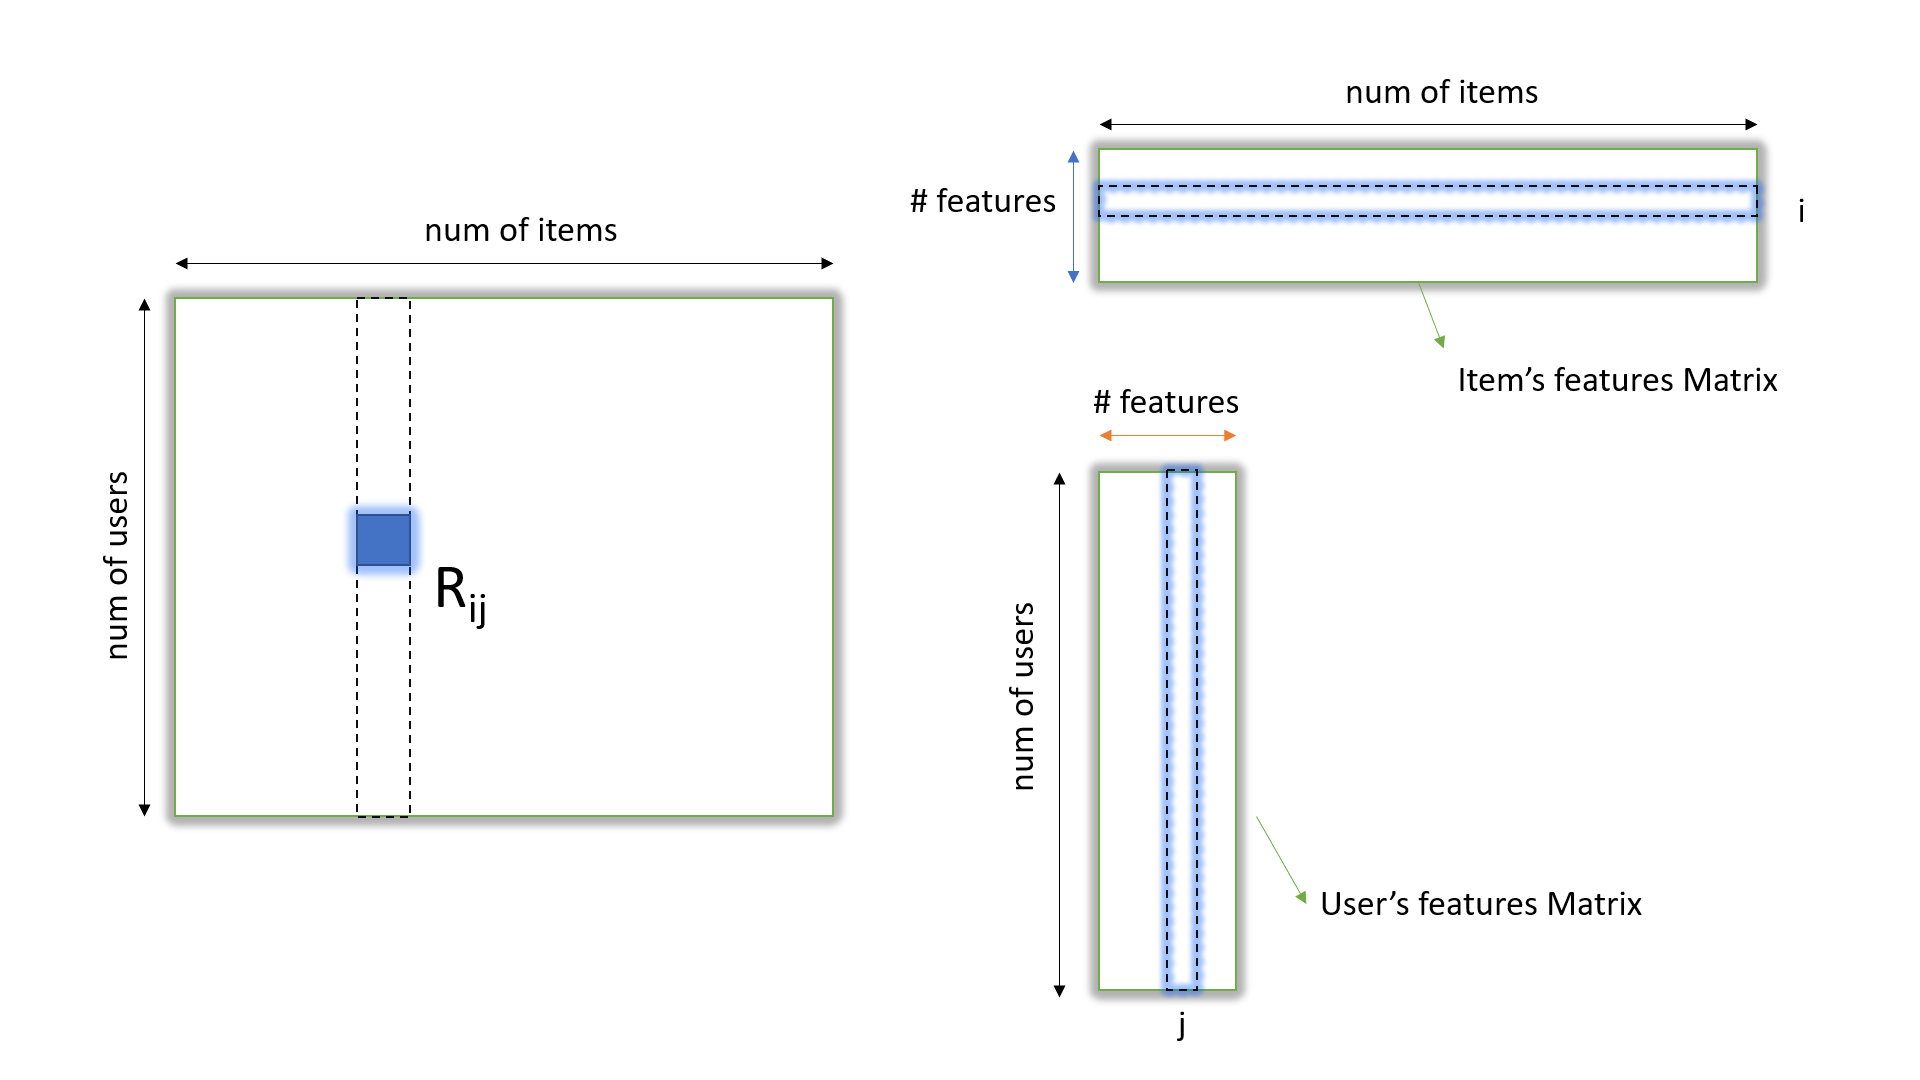

In [10]:
from IPython.display import Image
Image("/content/drive/MyDrive/sample-datasets/Screenshot.png", width = 1200)

In [11]:
als = ALS(
  #rank use default 10: đâu đó ~10 Latent factors 
  #maxIter use default 10.
  #regParam use default 0.1
  userCol="userId", 
  itemCol="movieId",
  ratingCol="rating", 
  nonnegative = True, #Ta mong đợi dữ liệu ratings dự đoán > 0
  implicitPrefs = False, # true for implicit approach, Tính toán dựa trên quan sát hoạt động của người dùng
  coldStartStrategy="drop" # Drop Nan value trong predictions để đảm bảo good evaluation 
)
start = time.time()
model = als.fit(training)
predictions = model.transform(test)
end = time.time()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
print("ALS completed in {:.4f} seconds" .format(end-start))

Root-mean-square error = 0.8818820006174695
ALS completed in 17.6979 seconds


In [12]:
recomendations = model.recommendForAllUsers(10)
recomendations.show(5)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[{26810, 4.733689...|
|   463|[{138966, 4.86763...|
|   496|[{96004, 4.770493...|
|   148|[{166534, 4.91571...|
|   540|[{7842, 5.5341268...|
+------+--------------------+
only showing top 5 rows



In [13]:
recomendations_for_471 = recomendations.filter(recomendations.userId == 471).select("recommendations").collect()[0][0]

In [14]:
pd.DataFrame(recomendations_for_471, columns=("movieId", "prediction"))

,movieId,prediction
0,26810,4.733689
1,177593,4.565861
2,78836,4.555291
3,6666,4.532682
4,184245,4.522343
5,117531,4.522343
6,26073,4.522343
7,72171,4.522343
8,84273,4.522343
9,7071,4.522343


In [16]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(als.regParam, [0.1, 0.01]) \
    .addGrid(als.rank, range(4, 12)) \
    .build()

crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(training)

In [18]:
cvModel_pred = cvModel.transform(test)
rmse2 = evaluator.evaluate(cvModel_pred)
print("Root-mean-square error = " + str(rmse2))

Root-mean-square error = 0.8840423090576498


Tuning model better but take longer. 